# Colouring Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# dataset = pd.read_csv('resources/observation_example.csv',na_values='')
dataset = pd.read_csv('resources/big.csv',na_values='')
dataset.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143416 entries, 0 to 143415
Columns: 17 entries, @timestamp to errseverity
dtypes: float64(2), int64(2), object(13)
memory usage: 18.6+ MB


Let's analyze how many uniques are in this dataset.

In [3]:
def perc(field):
    return len( dataset[field].unique() ) / len( dataset ) * 100.0

In [4]:
for col in dataset.columns:
    print('Percentage of unique %12s = %.1f%%' % (col, perc(col)))

Percentage of unique   @timestamp = 50.3%
Percentage of unique      logtype = 0.0%
Percentage of unique       system = 0.0%
Percentage of unique      loghost = 0.0%
Percentage of unique     hostname = 0.0%
Percentage of unique      envname = 0.0%
Percentage of unique     procname = 0.1%
Percentage of unique       procid = 0.1%
Percentage of unique       module = 0.1%
Percentage of unique     keywname = 0.1%
Percentage of unique    keywvalue = 0.0%
Percentage of unique     keywmask = 0.0%
Percentage of unique      logtext = 31.4%
Percentage of unique     errstack = 5.6%
Percentage of unique  errstackidx = 0.2%
Percentage of unique  errlocation = 0.1%
Percentage of unique  errseverity = 0.0%


The variability of *logtext* field make that column unsuitable to be analyzed from PARAVER. Several fields holds the same semantic but with varying parameters, for example in:

In [5]:
dataset[ dataset['logtext'].str.contains('Field tracking', regex=False) ]['logtext'].to_list()
# [ i for i in dataset['logtext'].to_list() if 'Field tracking' in i ]

['Field tracking on FT setpoint arm 1 : 3.057483050350e+02 2.688180753040e+02',
 'Field tracking on FT setpoint arm 3 : 1.267090794500e+03 2.487993467880e+02',
 'Field tracking on FT setpoint arm 2 : 8.177221274470e+02 2.710586049820e+02',
 'Field tracking on FT setpoint arm 4 : 1.713893946880e+03 2.564302475970e+02']

In [6]:
dataset[ dataset['logtext'].str.contains('SETPNT', regex=False) ]['logtext'].to_list()
# [ i for i in dataset['logtext'].to_list() if 'SETPNT' in i ]

['Send command SETPNT Y3VA, 1.314826 to process gvittpServer@lgvttp',
 'Send command SETPNT X1VA, -1.135904 to process gvittpServer@lgvttp',
 'Send command SETPNT Y2VA, -0.559927 to process gvittpServer@lgvttp',
 'Send command SETPNT X3VA, 1.024599 to process gvittpServer@lgvttp',
 'Send command SETPNT X4VA, -3.171247 to process gvittpServer@lgvttp',
 'Send command SETPNT Y1VA, 0.647595 to process gvittpServer@lgvttp',
 'Send command SETPNT X2VA, -1.990191 to process gvittpServer@lgvttp',
 'Send command SETPNT Y4VA, 3.373825 to process gvittpServer@lgvttp']

## Pre-processing strategy

The field *logtext* must be pre-processed using a regular expression provided by domain expert to remove parameters.

### Paranal Color

In [7]:
import re

# general purpose parameter removal
regex_symbols = re.compile(r"\W+")
regex_numbers = re.compile(r"('|:|\,|^| |\t|\.|\()\-*\d+(\-\d\d\-\d\dT\d\d)?e{0,1}")
regex_stopwords = re.compile(r"(\W|^)(at|to|on|for|s|with|by|is|the|of)(\W|$)")
regex_UTCdate = re.compile(r"\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}(\.\d{0,3})?")

# paranal specific regex
regex_telescope_prefix = re.compile(r"([lw][au]{0,1}t)[0-9]([a-z]+)")
regex_cmd = re.compile(r"cmd[0-9]+")
regex_fits = re.compile(r"([A-Za-z\d_])+\.fits")
regex_procname = re.compile(r"([a-z]+)_\d{4,}")
regex_obs_param = re.compile(r"((OBS|SEQ|INS)\.[A-Z:\._]+ )[A-Za-z\d_]+")
regex_mymerge = re.compile(r"mymerge_\d+")
regex_gravity1 = re.compile(r"TCSHDR_NGCIR1_\d+")

def colorize(l):
    """Applies substitutions in a string to remove irrelevant words or characters.
    General purpose parameter removal

    Args:
        l (string): string to be modified

    Returns:
        (string): modified string
    """
    l = regex_UTCdate.sub( r" ", l )
    l = regex_symbols.sub( r" ", l )
    l = regex_stopwords.sub( r"\1\3", l )
    l = regex_numbers.sub( r"\1", l)
    l = re.sub(' {2,}', ' ', l) 
    return l.strip().lower()

def color_paranal(l):
    """Applies substitutions in a string to remove irrelevant words or characters,
    according to paranal standards. Specific to PARANAL logs.

    Args:
        l (string): string to be modified

    Returns:
        (string): modified string
    """
    #replace in string l, any obs_param with 
    l = regex_obs_param.sub(r"\1", l)
    l = regex_procname.sub(r"\1_X", l)
    l = regex_fits.sub(r"0_fits", l)
    l = regex_telescope_prefix.sub(r"\1X\2", l)
    l = regex_mymerge.sub(r"_X", l)
    l = regex_gravity1.sub(r"_X", l)
    l = regex_cmd.sub(r"cmdX", l)
    return colorize(l)


### Examples

In [8]:
color_paranal('Send command SETPNT Y2VA, -0.568834 to process gvittpServer@lgvttp')

'send command setpnt y2va process gvittpserver lgvttp'

In [9]:
color_paranal('Field tracking on FT setpoint arm 1 : 3.055255707990e+02 2.688666011390e+02')

'field tracking ft setpoint arm'

## Dataset colorization

In [10]:
# Three step:
# 1) merge relevant fields
dataset['logcolor'] = dataset['keywname'].astype(str)+' '+dataset['logtext'].astype(str)

# 2) replace 'nan ' at the beginning
dataset['logcolor'] = dataset['logcolor'].str.replace('nan ', '')

# 3) Apply color
dataset['logcolor'] = dataset['logcolor'].apply( color_paranal )

In [11]:
col='logtext'
print('Percentage of unique %12s = %.1f%%' % (col, perc(col)))

col='logcolor'
print('Percentage of unique %12s = %.1f%%' % (col, perc(col)))

Percentage of unique      logtext = 31.4%
Percentage of unique     logcolor = 2.0%


## Analysis

### Histogram of frequencies by color 

In [12]:
colors = dataset[['logcolor']].copy()
colors['sum'] = 1
colors = colors.groupby(['logcolor'], axis=0).sum().sort_values(by='sum', ascending=False)

with pd.option_context('display.max_rows', 100):
    display(colors[['sum']])

sum
logcolor                                                
ccserr_db_quality point appl_data tcs nmmgr dat...  8093
seqerr_bad_quality watxtcs appl_data tcs nmmgr ...  8093
jump in utc time or illegal utc time actual tim...  6382
warning new header block added the fits file        3744
btk error signal x ttp volts                        2511
...                                                  ...
running initial ce points                              1
running initial ce done                                1
rtdcoreerr_socket_read error reading socket cli...     1
data quality gvar alias az_brake1disi value bad        1
loading calibration if available                       1

[2825 rows x 1 columns]

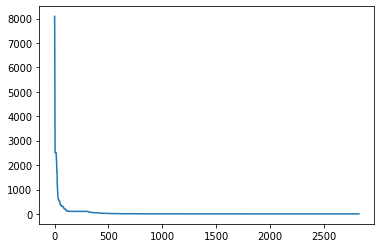

In [13]:
# Linear scale
plt.plot(colors['sum'].to_list())

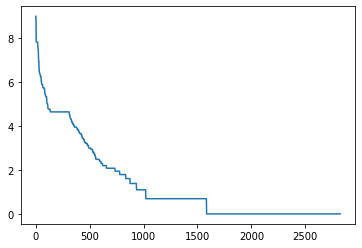

In [14]:
# Log scale
plt.plot(np.log(colors['sum']).to_list())

### Obtained colors (first only)

In [15]:
sorted( dataset['logcolor'].unique() )[:100]

['',
 '_fits ins fddl window ins fddl delay ins det2 gain ins det3 gain ins det2 qe ins det3 qe',
 'a',
 'a a obs start obs ntpl obs tplno dpr catg calib tpl did eso vlt dic tpl tpl id gravity_gen_cal_p2vm tpl name p2vm',
 'abort exposure blue',
 'absolute preset d m s target position deg timeout sec',
 'active rt algorithm resumed operation',
 'actual reference temperature c',
 'addfits done springgreen4',
 'addfits expoid detid ngcir1 info ins pola mode ft pola mode combined ins spec res ft rate exptime date obs tpl name',
 'addfits expoid detid ngcir1 info ins pola mode ft pola mode split ins spec res ft rate exptime date obs tpl name',
 'all requested heads initialized',
 'allowed laser range current lambda',
 'application ataltsrv a lcc software device',
 'application atauxsrv a lcc software device',
 'application atcfd a lcc software device',
 'application atdcssrv a lcc software device',
 'application atm10 a lcc software device',
 'application atm2 a lcc software device',
 'app

### Unique words (first only)

In [16]:
unique_words = set(
    [ word for row in dataset['logcolor'].unique() for word in row.split() ]
)
print("There are %s unique words" % len(unique_words))
print(np.array( sorted(unique_words)[:300] ).reshape(15,20))

There are 2081 unique words
[['_' '_7' '_fits' '_x' 'a' 'abort' 'abs' 'absolute' 'ac' 'accepted'
  'access' 'accessing' 'ace' 'acetecarc' 'acetece2v47_eng'
  'acknowledgement' 'acq' 'acq_image' 'acqcam' 'acquisition']
 ['acs' 'acscompon' 'acsfanon' 'acsfault' 'acsonoff' 'acspump1on'
  'acspump2on' 'acsstatus' 'action' 'activated' 'activation' 'active'
  'actpos' 'actual' 'added' 'addfits' 'addr' 'address' 'adrcorr' 'after']
 ['ag_latxdcs' 'agfas' 'agserver' 'airinvalve' 'airmass' 'airoutvalve'
  'alarm' 'alarm_u_pressure' 'algorithm' 'alias' 'all' 'allocation'
  'allocmem' 'allowed' 'alpha' 'already' 'alrm_dmfrozen'
  'alrm_focusexcess' 'alrm_horcomaexcess' 'alrm_maxfluxexcess']
 ['alrm_oblastigmatismexcess' 'alrm_tiltexcess' 'alrm_tipexcess'
  'alrm_vertastigmatismexcess' 'alrm_vertcomaexcess' 'alrmlogger'
  'alrmserver' 'alt' 'alt_brake1disi' 'alt_brake2disi' 'alt_head1'
  'alt_ilendstopsai' 'alt_ilendstopsbi' 'alt_ilfaulti' 'alt_illockpin1i'
  'alt_illockpin2i' 'alt_ilmotionstopi' '